# Simulations with Gammapy

Here we show how to simulate the properties of one or more sources in a given field of view with the use of Gammapy. The basic ingredientes are:
- a skymodel to simulate, i.e. the source properties (spectral, spatial and temporal) plus the background;
- a dataset, which carries information on the FoV geometry, the energy range, the IRF properties;
- an observation object, which defines the exposure time, the starting time of the simulation and the pointing direction;

Then we can set the simulator class and perform the event sampling on the given sky-model.

Let's start with some basic imports:

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import time
import numpy as np
import threading
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.data import Observation, observatory_locations, FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    GaussianTemporalModel,
    ConstantTemporalModel,
    ExpDecayTemporalModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models
)

### Creation of the sky-model

First of all, we need define the source model. For simplicity, we consider a point-like source with a powerlaw spectral shape, at a random position (here Ra, Dec = 335°, 3°). We will not include temporal variability (but if you like, there are some examples in the box below..). For more models, please visit the Gammapy website at https://docs.gammapy.org/1.2/user-guide/model-gallery/index.html .

In [2]:
target = SkyCoord("335 deg", "3 deg", unit="deg", frame="icrs")
spatial_model = PointSpatialModel.from_position(target)

spectral_model = PowerLawSpectralModel(index=2, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV")

### some example of temporal variability:
#t_ref = Time("2024-06-25T00:00:00", format="isot", scale="utc")
#gaussian_model = GaussianTemporalModel(t_ref=t_ref.mjd * u.d, sigma=1 * u.hr)
#temporal_model = ExpDecayTemporalModel(t_ref=t_ref.mjd * u.d, t0=1 * u.hr)
temporal_model = ConstantTemporalModel(const=1)

Gammapy collects the spatial, temporal and spectral information into a single object, called `SkyModel`:

In [3]:
source_model = SkyModel(spectral_model = spectral_model,
                       spatial_model = spatial_model,
                       temporal_model = temporal_model,
                       name = "fake_src")

print(source_model)

SkyModel

  Name                      : fake_src
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ConstantTemporalModel
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    335.000   +/-    0.00 deg         
    lat_0                         :      3.000   +/-    0.00 deg         




We need to include the background as well. Let's consider the model taken from the IRF:

In [4]:
bkg = FoVBackgroundModel(dataset_name="my-dataset")

The full model (i.e. source plus background) can be stored into the `Models` object. It can handle a number of models!

In [5]:
full_model = Models([source_model, bkg])

print(full_model)

Models

Component 0: SkyModel

  Name                      : fake_src
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ConstantTemporalModel
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    335.000   +/-    0.00 deg         
    lat_0                         :      3.000   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (fro

## Create the dataset

Let's define the energy range, the pointing coordinates, the exposure time and the size of the field of view. Then we can load the IRF to be used for the simulation and we will create the observation properties:

In [6]:
# reconstruncted energy:
energy_axis = MapAxis.from_energy_bounds("0.012589254 TeV", "199.52623 TeV",
                                         nbin=10, per_decade=True)

# we pass also an axis to calculate the energy dispersion:
energy_axis_true = MapAxis.from_energy_bounds("0.001 TeV", "250 TeV", 
                                         nbin=10, per_decade=True, 
                                         name="energy_true")
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

In [7]:
# We consider an offset of 0.5° between the source and pointing positions:
pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [8]:
# Let's assume an exposure time of 5 hours:
livetime = 5 * u.hr

In [9]:
# Let's load an IRF for the South array:
path = "/Users/fabiopintore/LAVORO/CTA/1st_CTAO_SCHOOL/Notebooks/caldb/CTA-Performance-prod5-v0.1-South-20deg/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
irf = load_irf_dict_from_file(path)

In [10]:
# We can define a FoV geometry of a square of 5° by side and a square pixel of 0.01° by side, centered 
# at the pointing position:

geom = WcsGeom.create(
            skydir=pointing,
            width=(5, 5), #deg
            binsz=0.01, #deg
            frame="icrs",
            axes=[energy_axis],
            )

Now we can create the `Observation` object to store all the needed information for the observation. We assume that the observation starts today: 

In [11]:
time_ref = Time("2024-06-25T00:00:00", format="isot", scale="utc")
observation = Observation.create(
            obs_id="0001",
            pointing=pointing,
            livetime=livetime,
            irfs=irf,
            reference_time=time_ref,
            )

/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


Finally, we can create the `Dataset` object and we fill it with the full sky-model:

In [12]:
empty = MapDataset.create(
            geom,
            energy_axis_true=energy_axis_true,
            migra_axis=migra_axis,
            name="my-dataset",
            )
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

In [13]:
dataset.models = full_model

In [14]:
print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 1180634.30
  Total excess counts             : -1180634.30

  Predicted counts                : 1189047.93
  Predicted background counts     : 1180634.30
  Predicted excess counts         : 8413.63

  Exposure min                    : 7.53e+01 m2 s
  Exposure max                    : 7.53e+10 m2 s

  Number of total bins            : 10750000 
  Number of fit bins              : 10750000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 2378095.86

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : fake_src
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : ConstantTempor

## Let's simulate the events:

We call the `MapDatasetEventSampler` class, the core of the simulations in Gammapy, and we set a seed for the random generator. Then, we sampled the source and background events

In [15]:
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


In [16]:
# the number of source events is:
len(events.table[events.table["MC_ID"] == 1])

8427

In [17]:
# the number of background events is:
len(events.table[events.table["MC_ID"] == 0])

1179451

Events can be inspected with a quick look using the function `peek`:

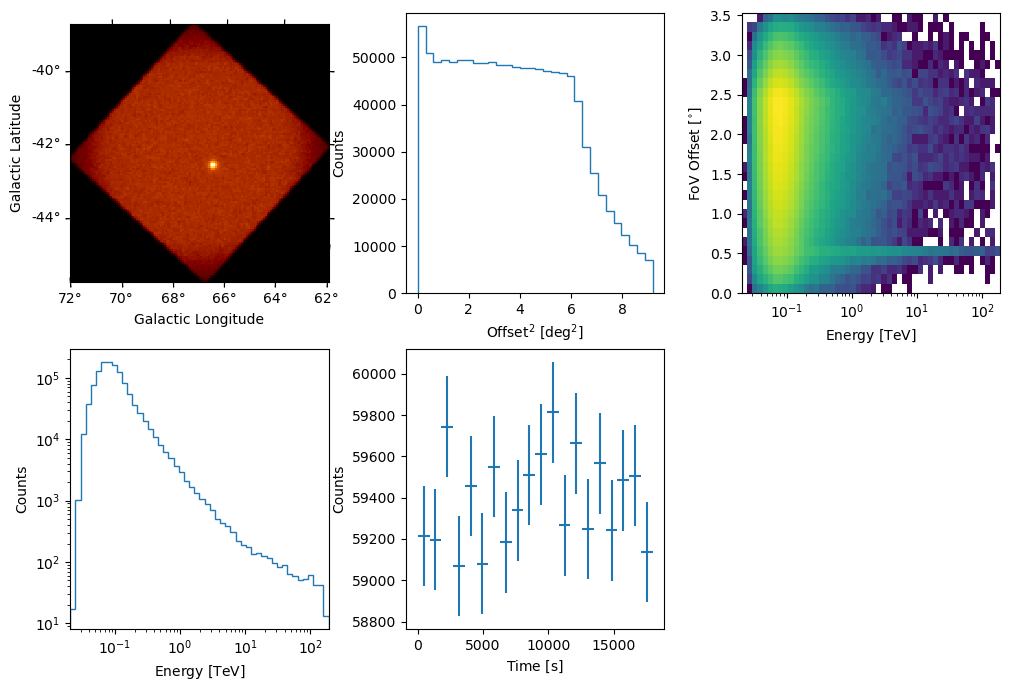

In [18]:
events.peek()

Now that we have generated the sampled events, we can proceed to fit them for example. However, before doing that, we need to fill the `dataset` with them:

In [19]:
counts = Map.from_geom(geom)
counts.fill_events(events)
dataset.counts = counts

## Open problems: 

1) Simulate a source with an extended morphology (for example, a Gaussian spatial extensions with size 0.5°) and a powerlaw spectral shape ($\Gamma=2$, amplitude=$10^{-13}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV). Determine then minimum exposure time needed to constrain the extension of the source to better than 10%; for simplicity, consider a FoV dimension of $2.5°\times2.5°$ and fix the source coordinates when fitting the model to the sampled data.
 
2) Consider an extended Galactic source at 1 kpc with a powerlaw spectral shape and a gaussian morphology with size 0.3°. Let's assume that its amplitude at 1 TeV is $10^{-12}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ and $\Gamma=2$.
Simulate it and fit the sampled events to estimate the size of its morpholgy. Then, move the source to larger distances, rescaling the powerlaw amplitude accordingly, and determine the morphology. Calculate how the constraints change with the distance. For simplicity, consider an exposure time of 10 hours and fix the source coordinates when fitting the model.